# Imports

In [1]:
import os
import numpy as np
import healpy as hp
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter as gfilter
import pandas
import gammalib

import minot
from PerseusGammaCalibration import perseus_model_library

cosmo = FlatLambdaCDM(70, 0.3, Ob0=0.0224/0.674**2)

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

# Main parameters 

In [2]:
version = 2
Nside = 1024
Npt_per_decade = 30  # Set the precision
use_psz_mass = False
do_validation = True

ne_gas_poly = True
Fx500_treshold = 50e-12 # erg/s/cm2

X_crp = 0.01
eta_crp = 1.0
alpha_crp = 2.2

workdir = '/Users/adam/Project/CTA/Phys/Outputs/CTADC2022/'

# Input catalog

In [3]:
#---------- Extract Accept info
accept = pandas.read_table('/Users/adam/Project/ExternalData/accept_main.tab', sep='\s+')
accept_name = []
accept_ra   = []
accept_dec  = []
accept_z    = []
accept_k0   = []
for icl in range(1, len(accept)):
    accept_coord_icl = SkyCoord(accept['RA'][icl]+accept['Dec'][icl], unit=(u.hourangle, u.deg), frame='icrs')
    accept_ra.append(accept_coord_icl.ra.to_value('deg'))
    accept_dec.append(accept_coord_icl.dec.to_value('deg'))
    accept_z.append(float(accept['z'][icl]))
    accept_k0.append(float(accept['K0'][icl]))
    accept_name.append(accept['#Name'][icl])
accept_name = np.array(accept_name)
accept_ra   = np.array(accept_ra)
accept_dec  = np.array(accept_dec)
accept_z    = np.array(accept_z)
accept_k0   = np.array(accept_k0)

#---------- Add info for important clusters (JPR sample)
accept_name = np.append(accept_name, 'A2634')
accept_ra = np.append(accept_ra, 354.57181275)
accept_dec = np.append(accept_dec, 27.02934221)
accept_z = np.append(accept_z, 0.031)
accept_k0 = np.append(accept_k0, 40.7) # https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'A1367')
accept_ra = np.append(accept_ra, 176.12366417)
accept_dec = np.append(accept_dec, 19.83883798)
accept_z = np.append(accept_z, 0.022)
accept_k0 = np.append(accept_k0, 296.5) # https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'A1656')
accept_ra = np.append(accept_ra, 194.95038236)
accept_dec = np.append(accept_dec, 27.97997795)
accept_z = np.append(accept_z, 0.023)
accept_k0 = np.append(accept_k0, 364.6) # https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'NGC1399')
accept_ra = np.append(accept_ra, 54.6157681)
accept_dec = np.append(accept_dec, -35.45277218)
accept_z = np.append(accept_z, 0.005)
accept_k0 = np.append(accept_k0, 13.6)# https://www.aanda.org/articles/aa/pdf/2010/05/aa12377-09.pdf

accept_name = np.append(accept_name, 'Virgo')
accept_ra = np.append(accept_ra, 186.63483418)
accept_dec = np.append(accept_dec, 12.7233333)
accept_z = np.append(accept_z, 0.0036)
accept_k0 = np.append(accept_k0, 0) # No entropy floor seen? https://academic.oup.com/mnras/article/469/2/1476/3738101

#---------- Add info for relevant clusters (Fx500/1e-11 > 5)
accept_name = np.append(accept_name, '3C 129.1')
accept_ra = np.append(accept_ra, 72.515)
accept_dec = np.append(accept_dec, 45.024)
accept_z = np.append(accept_z, 0.022)
accept_k0 = np.append(accept_k0, np.nan) # https://academic.oup.com/mnras/article/326/1/2/1026382

accept_name = np.append(accept_name, 'RXC J1324.7-5736')
accept_ra = np.append(accept_ra, 201.18)
accept_dec = np.append(accept_dec, -57.614)
accept_z = np.append(accept_z, 0.019)
accept_k0 = np.append(accept_k0, 0) # clear CC cluster http://www.aspbooks.org/publications/329/183.pdf

accept_name = np.append(accept_name, 'A3627')
accept_ra = np.append(accept_ra, 243.594)
accept_dec = np.append(accept_dec, -60.869)
accept_z = np.append(accept_z, 0.0157)
accept_k0 = np.append(accept_k0, np.nan) # https://academic.oup.com/pasj/article/64/1/16/1432259 (merging + CC)

accept_name = np.append(accept_name, 'Triangulum Australis')
accept_ra = np.append(accept_ra, 249.567)
accept_dec = np.append(accept_dec, -64.347)
accept_z = np.append(accept_z, 0.0508)
accept_k0 = np.append(accept_k0, 1e4) # https://arxiv.org/pdf/astro-ph/9606112.pdf

In [4]:
#---------- Extract MCXC info
mcxc = fits.open('/Users/adam/Project/ExternalData/Planck/Clusters/MCXC_official.fits')
mcxc_data = mcxc[1].data

mcxc_ra    = []
mcxc_dec   = []
mcxc_z     = []
mcxc_m     = []
mcxc_Lx    = []
for icl in range(len(mcxc_data)):
    mcxc_ra.append(mcxc_data[icl][10])
    mcxc_dec.append(mcxc_data[icl][11])
    mcxc_z.append(mcxc_data[icl][14])
    mcxc_m.append(mcxc_data[icl][19])
    mcxc_Lx.append(mcxc_data[icl][18])
mcxc_ra    = np.array(mcxc_ra)
mcxc_dec   = np.array(mcxc_dec)
mcxc_z     = np.array(mcxc_z)
mcxc_m     = np.array(mcxc_m)
mcxc_Lx    = np.array(mcxc_Lx)

In [5]:
#---------- Extract PSZ2 info
psz2 = fits.open('/Users/adam/Project/ExternalData/Planck/Clusters/HFI_PCCS_SZ-union_R2.08.fits')
psz2_data = psz2[1].data

### Version 1: HIFLUGCS + Perseus

In [6]:
if version == 1:
    #---------- Start with HIFLUGCS (https://www.aanda.org/articles/aa/olm/2015/03/aa24085-14/aa24085-14.html)
    cat_name = np.array(['2A0335','A0085','A0119','A0133','A0262','A0399','A0400','A0401','A0478','A0496','A0576','A0754','A1060','A1367','A1644','A1650','A1651','A1656','A1736','A1795','A2029','A2052','A2063','A2065','A2142','A2147','A2163','A2199','A2204','A2255','A2256','A2589','A2597','A2634','A2657','A3112','A3158','A3266','A3376','A3391','A3395','A3526','A3558','A3562','A3571','A3581','A3667','A4038','A4059','EXO0422','HydraA','IIIZw54','MKW3S','MKW4','MKW8','NGC1399','NGC1550','NGC4636','NGC5044','NGC507','RXCJ1504','S1101','ZwCl1215', 'A2244', 'A0426'])
    cat_ra   = np.array([54.6714,10.4600,14.0668,15.6741,28.1926,44.4727,44.4233,44.7361,63.3548,68.4081,110.3761,137.3194,159.1781,176.2512,194.2991,194.6728,194.8423,194.8989,201.7161,207.2191,227.7336,229.1813,230.7713,230.6222,239.5860,240.5699,243.9445,247.1597,248.1956,258.1423,255.8094,350.9892,351.3330,354.6219,356.2395,49.4902,55.7178,67.8047,90.5360,96.5854,96.7073,192.2035,201.9870,203.4054,206.8680,211.8758,303.1778,356.9299,359.2539,66.4635,139.5254,55.3235,230.4656,181.1128,220.1795,54.6213,64.9082,190.7080,198.8495,20.9159,226.0313,348.4933,184.4238, 255.677375, 49.950667])
    cat_dec  = np.array([9.9672,-9.3031,-1.2557,-21.8822,36.1541,13.0313,6.0271,13.5777,10.4649,-13.2611,55.7641,-9.6891,-27.5283,19.6751,-17.4090,-1.7619,-4.1970,27.9597,-27.1741,26.5925,5.7448,7.0222,8.6075,27.7062,27.2303,15.9738,-6.1501,39.5503,5.5754,64.0699,78.6500,16.7772,-12.1243,27.0317,9.1919,-44.2384,-53.6321,-61.4531,-39.9468,-53.6936,-54.5427,-41.3122,-31.4953,-31.6714,-32.8660,-27.0196,-56.8468,-28.1420,-34.7593,-8.5605,-12.0958,15.3936,7.7080,1.8961,3.4660,-35.4502,2.4101,2.6868,-16.3852,33.2560,-2.8047,-42.7253,3.6551, 34.06037222, 41.511696])
    cat_z    = np.array([0.0349,0.0556,0.0440,0.0569,0.0161,0.0715,0.0240,0.0748,0.0848,0.0328,0.0381,0.0528,0.0114,0.0216,0.0474,0.0845,0.0860,0.0232,0.0461,0.0616,0.0767,0.0348,0.0354,0.0721,0.0899,0.0351,0.2010,0.0302,0.1523,0.0800,0.0601,0.0416,0.0852,0.0312,0.0404,0.0750,0.0590,0.0594,0.0455,0.0531,0.0498,0.0103,0.0480,0.0499,0.0374,0.0214,0.0560,0.0283,0.0460,0.0390,0.0538,0.0311,0.0450,0.0200,0.0270,0.0046,0.0123,0.0037,0.0090,0.0165,0.2153,0.0580,0.0750, 0.0967, 0.0179])
    
    #---------- mass from MCXC matching
    no_mass_count = 0
    cat_mass = cat_z*0
    for icl in range(len(cat_name)):
        dist = minot.ClusterTools.map_tools.greatcircle(mcxc_ra, mcxc_dec, cat_ra[icl], cat_dec[icl])
        c1 = (dist < 10.0/60)
        c2 = np.abs(mcxc_z - cat_z[icl]) < 0.1
        w    = c1*c2
        if np.sum(w) == 1: 
            cat_mass[icl] = mcxc_m[w][0]
        else:
            print('WARNING: Nmatch=', np.sum(w), str(i+1)+'/'+str(len(cat_name)), cat_name[icl])
            cat_mass[icl] = np.nan
    print('No mass for '+str(no_mass_count)+'/'+str(len(cat_name)))
        
    #---------- K0 from ACCEPT matching
    no_k0_count = 0
    cat_K0 = cat_mass*0
    for icl in range(len(cat_name)):
        dist = minot.ClusterTools.map_tools.greatcircle(accept_ra, accept_dec, cat_ra[icl], cat_dec[icl])
        c1 = (dist < 20.0/60)
        c2 = np.abs(accept_z - cat_z[icl]) < 0.1
        w    = c1*c2
        if np.sum(w) == 1: 
            cat_K0[icl] = accept_k0[w][0]
        else:
            print('WARNING: Nmatch=', np.sum(w), cat_name[icl])
            cat_K0[icl] = np.nan
            no_k0_count+=1
    print('No K0 for '+str(no_k0_count)+'/'+str(len(cat_name)))

### Version 2: MCXC threshold on F_X500 (i.e. mainly REFLEX/NORAS/CIZA)

In [7]:
if version == 2:
    cat_name = []
    cat_ra   = []
    cat_dec  = []
    cat_z    = []
    cat_mass = []
    cat_K0   = []
    cat_cat  = []

    #---------- Start with MCXC and treshold it
    no_k0_count = 0
    for icl in range(len(mcxc[1].data)):
        Dl = cosmo.luminosity_distance(mcxc[1].data[icl][14]).to_value('cm')
        if 1e44*mcxc[1].data[icl][18]**1.2/(4*np.pi*Dl**2) > Fx500_treshold: 
            if mcxc[1].data[icl][2] == '':
                cat_name.append(mcxc[1].data[icl][1].replace(" ", "_"))
            else:
                cat_name.append(mcxc[1].data[icl][2].replace(" ", "_"))
                
            cat_ra.append(mcxc_data[icl][10])
            cat_dec.append(mcxc_data[icl][11])
            cat_z.append(mcxc_data[icl][14])
            cat_mass.append(mcxc_data[icl][19])
            cat_cat.append(mcxc_data[icl][16])

            #---------- Match to ACCEPT to get entropy
            dist = minot.ClusterTools.map_tools.greatcircle(accept_ra, accept_dec, 
                                                            mcxc[1].data[icl][10], mcxc_data[icl][11])
            c1 = (dist < 10.0/60)
            c2 = np.abs(accept_z - mcxc_data[icl][14]) < 0.1
            w    = c1*c2
            if np.sum(w) == 1: 
                cat_K0.append(accept_k0[w][0])
            else:
                print('     WARNING: Nmatch=', np.sum(w), 
                      1e44*mcxc[1].data[icl][18]**1.2/(4*np.pi*Dl**2)/Fx500_treshold, 
                      mcxc_data[icl][10], mcxc_data[icl][11], mcxc_data[icl][14],
                      mcxc[1].data[icl][1], mcxc[1].data[icl][2])
                cat_K0.append(np.nan)
                no_k0_count+=1
    print('No K0 for '+str(no_k0_count)+'/'+str(len(cat_name)))
    
    cat_name = np.array(cat_name)
    cat_ra   = np.array(cat_ra)
    cat_dec  = np.array(cat_dec)
    cat_z    = np.array(cat_z)
    cat_mass = np.array(cat_mass)
    cat_K0   = np.array(cat_K0)
    cat_cat  = np.array(cat_cat)

No K0 for 0/34


### Version 3: Judit DM based catalog

In [8]:
if version == 3:
    #---------- JPR inputs
    cat_name = np.array(['A0478','A0399','A2065','A1736','A1644','A0401','A2029','HydraA','ZwCl1215','MKW3s','A0133','A3158','A4059','A1795','A2657','A2147','A3376','A3562','A0085','A3391','A3667','A2052','2A0335','A2589','EXO0422','A0576','A2063','A3558','A2142','A0119','A2634','A2256','A0496','A3266','A1367','A4038','A0754','A2199','A3571','NGC5044','NGC5813','Ophiuchus','A1656','A0426','NGC5846','A1060','A3526','NGC1399','M49','NGC4636','Virgo'])
    cat_glon = np.array([182.41,164.37,42.880,312.58,304.91,164.18,6.5000,242.93,282.50,11.390,149.76,265.07,356.83,33.790,96.650,28.810,246.53,313.31,115.05,262.36,340.85,9.3900,176.25,94.660,203.30,161.42,12.850,311.98,44.230,125.70,103.45,111.10,209.59,272.09,234.80,24.890,239.25,62.900,316.32,311.23,359.18,0.5800,58.090,150.57,0.4300,269.63,302.41,236.72,286.92,297.75,279.68])
    cat_glat = np.array([-28.30,-39.47,+56.56,+35.10,+45.50,-38.87,+50.55,+25.09,+65.19,+49.45,-84.23,-48.97,-76.06,+77.16,-50.30,+44.49,-26.29,+30.35,-72.06,-25.26,-33.40,+50.10,-35.08,-41.20,-36.16,+26.24,+49.71,+30.74,+48.69,-64.10,-33.06,+31.74,-36.49,-40.17,+73.03,-75.82,+24.76,+43.70,+28.55,+46.10,+49.85,+9.290,+87.96,-13.26,+48.80,+26.51,+21.56,-53.64,+70.17,+65.47,+74.46])
    cat_z    = np.array([0.085,0.071,0.072,0.046,0.047,0.075,0.077,0.054,0.075,0.045,0.057,0.059,0.046,0.062,0.04,0.035,0.045,0.05,0.056,0.053,0.056,0.035,0.035,0.042,0.039,0.038,0.035,0.048,0.09,0.044,0.031,0.06,0.033,0.059,0.022,0.028,0.053,0.03,0.037,0.009,0.0064,0.028,0.023,0.0183,0.0061,0.011,0.01,0.005,0.0044,0.004,0.0036])
    cat_M200 = np.array([6.082,4.026,4.729,1.454,1.549,5.922,6.592,2.604,6.538,1.659,3.348,3.971,2.194,5.168,1.691,1.172,2.582,3.534,5.093,4.514,5.301,1.629,1.664,2.994,2.492,2.372,1.974,4.886,28.03,3.956,1.554,10.172,2.561,13.44,0.878,2.231,24.998,5.07,10.904,0.411,0.271,23.164,13.158,7.714,0.379,2.966,2.266,0.506,0.464,0.534,5.6])
    
    #---------- Get RA Dec
    cat_coord = SkyCoord(cat_glon, cat_glat, unit=u.deg, frame='galactic')
    cat_ra = cat_coord.icrs.ra.value
    cat_dec = cat_coord.icrs.dec.value

    #---------- Get M500
    cat_mass = cat_M200*0
    for icl in range(len(cat_name)): 
        cat_mass[icl] = minot.ClusterTools.cluster_global.Mdelta1_to_Mdelta2_NFW(cat_M200[icl], 
                                                                                 delta1=200, delta2=500, 
                                                                                 c1=5.0, redshift=cat_z[icl], 
                                                                                 cosmo=cosmo)
    #---------- Get K0
    no_k0_count = 0
    cat_K0 = cat_M200*0
    for icl in range(len(cat_name)):
        dist = minot.ClusterTools.map_tools.greatcircle(accept_ra, accept_dec, cat_ra[icl], cat_dec[icl])
        c1 = (dist < 20.0/60)
        c2 = np.abs(accept_z - cat_z[icl]) < 0.1
        w    = c1*c2
        if np.sum(w) == 1: 
            cat_K0[icl] = accept_k0[w][0]
        else:
            print('WARNING: Nmatch=', np.sum(w), cat_name[icl])
            cat_K0[icl] = np.nan
            no_k0_count+=1
    print('No K0 for '+str(no_k0_count)+'/'+str(len(cat_name)))

### Add Y and Lx info for validation

In [9]:
#---------- Lx500 from MCXC
no_Lx_count = 0
cat_Lx_mcxc = cat_z*0
cat_Lx_mod  = cat_z*0
for icl in range(len(cat_name)):
    dist = minot.ClusterTools.map_tools.greatcircle(mcxc_ra, mcxc_dec, cat_ra[icl], cat_dec[icl])
    c1 = (dist < 10.0/60)
    c2 = np.abs(mcxc_z - cat_z[icl]) < 0.1
    w    = c1*c2
    if np.sum(w) == 1: 
        cat_Lx_mcxc[icl] = mcxc_Lx[w][0]
    else:
        print('WARNING: Nmatch=', np.sum(w), str(icl+1)+'/'+str(len(cat_name)), cat_name[icl])
        cat_Lx_mcxc[icl] = np.nan
        no_Lx_count+=1
print('No Lx for '+str(no_Lx_count)+'/'+str(len(cat_name)))

No Lx for 0/34


In [10]:
#---------- Y500 from PSZ2
no_y_count = 0
cat_y_psz2 = cat_z*0
cat_yerr_psz2 = cat_z*0
cat_m_psz2 = cat_z*0
cat_merr_psz2 = cat_z*0
cat_y_mod  = cat_z*0
for icl in range(len(cat_name)):
    dist = minot.ClusterTools.map_tools.greatcircle(psz2_data['RA'], psz2_data['Dec'], cat_ra[icl], cat_dec[icl])
    c1 = (dist < 10.0/60)
    c2 = np.abs(psz2_data['redshift'] - cat_z[icl]) < 0.1
    w    = c1*c2
    if np.sum(w) == 1: 
        cat_y_psz2[icl] = psz2_data['Y5R500'][w][0]
        cat_m_psz2[icl] = psz2_data['MSZ'][w][0]
        cat_yerr_psz2[icl] = psz2_data['Y5R500_ERR'][w][0]
        cat_merr_psz2[icl] = (psz2_data['MSZ_ERR_LOW'][w][0]+psz2_data['MSZ_ERR_UP'][w][0])/2
    else:
        print('WARNING: Nmatch=', np.sum(w), str(icl+1)+'/'+str(len(cat_name)), cat_name[icl])
        cat_y_psz2[icl] = np.nan
        cat_m_psz2[icl] = np.nan      
        cat_yerr_psz2[icl] = np.nan
        cat_merr_psz2[icl] = np.nan
        no_y_count+=1
print('No Y for '+str(no_y_count)+'/'+str(len(cat_name)))

if use_psz_mass:
    cat_mass[cat_m_psz2/cat_m_psz2 == 1] = cat_m_psz2[cat_m_psz2/cat_m_psz2 == 1]

No Y for 10/34


# Compute sky maps looping over catalog

In [11]:
#---------- Energy bining definition
Ebin_emin = 100*u.GeV
Ebin_emax = 100*u.TeV
Ebin_nbin = 3

Ebin_pot    = np.logspace(np.log10(Ebin_emin.to_value('GeV')), 
                          np.log10(Ebin_emax.to_value('GeV')), 
                          Ebin_nbin+1)*u.GeV
Ebin_ctr    = ((Ebin_pot + np.roll(Ebin_pot,1))/2)[1:]
Ebin_logctr = 10**((np.log10(Ebin_pot.to_value('GeV')) + np.roll(np.log10(Ebin_pot.to_value('GeV')),1))/2)[1:]

Ebin_pot, Ebin_ctr, Ebin_logctr

(<Quantity [   100.,   1000.,  10000., 100000.] GeV>,
 <Quantity [  550.,  5500., 55000.] GeV>,
 array([  316.22776602,  3162.27766017, 31622.77660168]))

In [12]:
#---------- Helpix bining
skymap = np.zeros((Ebin_nbin, hp.nside2npix(Nside)))

In [13]:
#---------- Init the healpix to get lon and lat maps
bid_cl = minot.Cluster(silent=True)
bid_map, lon, lat = bid_cl.get_gamma_hpmap(nside=Nside, output_lonlat=True)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/pixelfunc.py:528: RuntimeWarning: divide by zero encountered in _pix2ang_ring
  theta, phi = pixlib._pix2ang_ring(nside, ipix)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/pixelfunc.py:528: RuntimeWarning: invalid value encountered in _pix2ang_ring
  theta, phi = pixlib._pix2ang_ring(nside, ipix)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


In [14]:
K0_limits = [25, 70] # Used to define cool-cores, morphologically disturbed or universal clusters

TemplateDir = workdir+'Template_X_'+str(X_crp)+'_alpha_'+str(alpha_crp)+'_eta'+str(eta_crp)
if not os.path.exists(TemplateDir): os.mkdir(TemplateDir)
model_tot = gammalib.GModels()

for icl in range(len(cat_name)):
    print(str(icl+1)+'/'+str(len(cat_name)), cat_name[icl], cat_ra[icl], cat_dec[icl], cat_mass[icl], cat_z[icl])
    
    #---------- Special case for Perseus
    if cat_name[icl] == 'A0426': 
        cluster = perseus_model_library.default_model()
        cluster.name = 'A0426'
        cluster.output_dir = workdir
        cluster.Npt_per_decade_integ = Npt_per_decade
        cluster.R_truncation = 3*cluster.R500
        cluster.map_coord = cluster.coord
        cluster.map_reso = 0.01*u.deg
        cluster.map_fov = 2.5*cluster.theta_truncation
        '''
        for ieb in range(Ebin_nbin):
            map_ebin = cluster.get_gamma_hpmap(nside=Nside, 
                                               Emin=Ebin_pot[ieb], Emax=Ebin_pot[ieb+1], 
                                               Rmin_los=1*u.kpc, NR500_los=3.0, Rmin=1*u.kpc, Rmax=3*cluster.R500, 
                                               Energy_density=False, Cframe=False, model='Kafexhiu2014', 
                                               maplonlat=[lon,lat], output_lonlat=False)
            skymap[ieb,:] += map_ebin.to_value('s-1 sr-1 cm-2')
        '''
    #---------- Otherwise build a standard model
    elif cat_mass[icl]/cat_mass[icl] == 1:
        # Init the model
        cluster = minot.Cluster(name=cat_name[icl], M500=cat_mass[icl]*1e14*u.Msun, redshift=cat_z[icl], 
                                RA=cat_ra[icl]*u.deg, Dec=cat_dec[icl]*u.deg, 
                                cosmology=cosmo, silent=True, output_dir=workdir)
        cluster.Npt_per_decade_integ = Npt_per_decade
        cluster.R_truncation = 3*cluster.R500
        cluster.map_coord = SkyCoord(cat_ra[icl]*u.deg, cat_dec[icl]*u.deg, frame='icrs')
        cluster.map_reso = 0.01*u.deg
        cluster.map_fov = 2.5*cluster.theta_truncation
        
        # Select the thermodynamic profile using K0
        if cat_K0[icl] is np.nan:                                            # Undefined --> UPP
            cluster.set_pressure_gas_gNFW_param(pressure_model='A10UPP')
            cluster.set_density_gas_universal_param(density_model='G19UDP')
        else:
            if cat_K0[icl] < K0_limits[0]:                                   # Low K0 --> CC
                cluster.set_pressure_gas_gNFW_param(pressure_model='A10CC')
                cluster.set_density_gas_universal_param(density_model='G19CC')
            elif cat_K0[icl] >= K0_limits[0] and cat_K0[icl] < K0_limits[1]: # Intermediate K0 --> CC
                cluster.set_pressure_gas_gNFW_param(pressure_model='A10UPP')
                cluster.set_density_gas_universal_param(density_model='G19UDP')
            else:                                                            # High K0 --> MD
                cluster.set_pressure_gas_gNFW_param(pressure_model='A10MD')
                cluster.set_density_gas_universal_param(density_model='G19MD')
        
        # Try polytropic expectation for density
        if ne_gas_poly:
            rad, prof = cluster.get_pressure_gas_profile(radius=np.logspace(-1,4,10000)*u.kpc)
            E_z   = cluster.cosmo.efunc(cluster.redshift)
            h70   = cluster.cosmo.H0.value/70.0
            mu_g,mu_e,mu_p,mu_a = minot.ClusterTools.cluster_global.mean_molecular_weight(Y=cluster.helium_mass_fraction,
                                                                                          Z=cluster.metallicity_sol*cluster.abundance)
            P500 = 3.426*1e-3 * (cluster.M500.to_value('Msun')*h70/1e15)**(2.0/3) * E_z**(8.0/3) * ((cluster.cosmo.Ob0/cluster.cosmo.Om0)/0.16)*(mu_g/0.6)*(mu_e/1.14)
            P0 = np.exp(-2.94)
            n0 = np.exp(-10.3)
            Gamma = 1.19
            profile = (prof.to_value('keV cm-3')/(P500*P0))**(1/Gamma) * n0*E_z**2 * u.cm**-3
            cluster.density_gas_model = {'name':'User', 'radius':rad, 'profile':profile}
        
        # Set the CR
        cluster.X_cre1_E = {'X':0,    'R_norm':cluster.R500}
        cluster.X_crp_E  = {'X':X_crp, 'R_norm':cluster.R500}
        cluster.set_density_crp_isodens_scal_param(scal=eta_crp)
        cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index': alpha_crp}
    
    #---------- Compute the sky map in each energy bin and sum
    for ieb in range(Ebin_nbin):
        map_ebin = cluster.get_gamma_hpmap(nside=Nside, 
                                           Emin=Ebin_pot[ieb], Emax=Ebin_pot[ieb+1], 
                                           Rmin_los=1*u.kpc, NR500_los=3.0, Rmin=1*u.kpc, Rmax=3*cluster.R500, 
                                           Energy_density=False, Cframe=False, model='Kafexhiu2014', 
                                           maplonlat=[lon,lat], output_lonlat=False)
        skymap[ieb,:] += map_ebin.to_value('s-1 sr-1 cm-2')
    
    if do_validation:
        #---------- Check the model with Y comparison
        cat_y_mod[icl] = 1e3*(cluster.get_sz_flux(Compton_only=True, 
                                                  Rmin=1*u.kpc, Rmin_los=1*u.kpc,
                                                  Rmax=cluster.R_truncation)[0]/cluster.D_ang**2).to_value('')*(60*180/np.pi)**2
        #---------- Check the model with Lx comparison
        cluster.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV, 
                                 Tmin=0.1*u.keV,Tmax=30.0*u.keV, nbin=10, 
                                 nH=0*u.cm**-2, app_nH_model=False)
        cat_Lx_mod[icl] = 1e-44*(cluster.get_xray_flux(Rmax=cluster.R500, Rmin=1*u.kpc, Rmin_los=1*u.kpc, Cframe=True,
                                                       type_integral='spherical', output_type='S')*4*np.pi*cluster.D_lum**2).to_value('erg s-1')
        
    #---------- Compute the templates
    #----- Map
    header = cluster.get_map_header()
    image = cluster.get_gamma_map(Emin=5e-2*u.TeV, Emax=1e+2*u.TeV, # Emin/Emax not important since normalized
                                  Rmin_los=None, NR500_los=5.0, Rmin=None, Rmax=None,
                                  Normalize=True)
    hdu = fits.PrimaryHDU(header=header)
    hdu.data = image.value
    hdu.header.add_comment('Gamma-ray normalized map')
    hdu.header.add_comment('Unit = '+str(image.unit))
    hdu.writeto(TemplateDir+'/TemplateMap_'+cluster.name+'.fits', overwrite=True)

    #----- Spectrum
    energy = np.logspace(-2,6,1000)*u.GeV
    eng, spec = cluster.get_gamma_spectrum(energy,
                                           Rmin=None, Rmax=cluster.R_truncation, Rmin_los=None, NR500_los=5.0,
                                           type_integral='spherical')
    wgood  = spec > 0
    energy = energy[wgood]
    spec   = spec[wgood]
    cluster._save_txt_file(TemplateDir+'/TemplateSpectrum_'+cluster.name+'.txt', 
                           energy.to_value('MeV'), spec.to_value('MeV-1 cm-2 s-1'),
                           'energy (MeV)', 'spectrum (MeV-1 cm-2 s-1)')
    
    #----- Add model
    spatial  = gammalib.GModelSpatialDiffuseMap(TemplateDir+'/TemplateMap_'+cluster.name+'.fits')
    spectral = gammalib.GModelSpectralFunc(TemplateDir+'/TemplateSpectrum_'+cluster.name+'.txt', 1.0)
    timing   = gammalib.GModelTemporalConst(1)
    model    = gammalib.GModelSky(spatial, spectral, timing)
    model.name(cluster.name)
    model.tscalc(True)
    model_tot.append(model)
    
model_tot.save(TemplateDir+'/ClusterTemplates.xml')

1/34 A0085 10.459 -9.302 5.3163 0.0555


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


2/34 A0262 28.195 36.151 1.1891 0.0163


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


3/34 AWM_7 43.623 41.572 1.8346 0.0172


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


4/34 A0401 44.74 13.58 5.8488 0.0739


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


5/34 A0426 49.947 41.513 6.1508 0.0179


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


6/34 2A0335 54.67 9.974 3.4496 0.0347


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


7/34 A0478 63.356 10.467 6.424 0.0882


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


8/34 A3266 67.85 -61.444 4.5579 0.0589


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


9/34 A0496 68.41 -13.259 2.9118 0.0326


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


10/34 3C_129.1 72.515 45.024 1.8897 0.022


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


11/34 PKS0745-19 116.885 -19.292 7.9855 0.1028


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


12/34 A0754 137.285 -9.666 4.4824 0.0542


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


13/34 A1060 159.174 -27.524 0.9944 0.0126


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


14/34 A1367 176.152 19.759 2.1398 0.0214


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


15/34 Virgo 187.697 12.337 1.2092 0.0036


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ebltable/tau_from_model.py:307: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon

16/34 A3526 192.2 -41.308 1.6218 0.0114


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


17/34 Coma 194.929 27.939 4.2846 0.0231


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


18/34 RXC_J1324.7-5736 201.18 -57.614 1.6812 0.019


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


19/34 A3558 201.99 -31.503 3.9741 0.048


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


20/34 A3571 206.868 -32.85 4.5067 0.0391


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


21/34 A1795 207.221 26.596 5.528 0.0622


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


22/34 A2029 227.729 5.72 7.2708 0.0766


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


23/34 A2052 229.183 7.018 2.4945 0.0353


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


24/34 A2142 239.586 27.227 8.1491 0.0894


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


25/34 A2147 240.578 16.02 2.4052 0.0353


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


26/34 A3627 243.594 -60.869 2.136 0.0157


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


27/34 A2199 247.158 39.549 2.9626 0.0299


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


28/34 Triangulum_Australis 249.567 -64.347 5.235 0.0508


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


29/34 A2256 255.953 78.644 4.2502 0.0581


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


30/34 Ophiuchus 258.103 -23.35 5.3123 0.028


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


31/34 A2319 290.287 43.958 5.8345 0.0557


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


32/34 Cygnus_A 299.876 40.736 4.2185 0.0561


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


33/34 A3667 303.127 -56.832 5.1696 0.0556


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


34/34 A4038 356.93 -28.141 2.0383 0.03


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/minot/ClusterTools/map_tools.py:216: RuntimeWarning: invalid value encountered in sin
  arg4 = (np.sin((lon_ref-lon)*np.pi/180.0/2.0))**2


In [15]:
coord_liat = ['20:09:27.0 -48:49:52', '23:59:09.42 -30:37:22.7', '15:55:44.7 +11:11:41', '16:14:19.2 -51:49:12', '16:16:24.0 -50:54:00', '16:32:09.6 -47:49:12', '16:34:57.6 -47:16:12', '16:40:38 -46:34:23', '17:02:44 -42:00:57', '17:08:24 -41:05:24', '17:13:57.6 -38:12:00', '17:45:02.10 -30:22:14.00', '17:47:23.2 -28:09:06', '18:04:31.2 -21:42:00', '18:13:36.0 -17:50:24', '18:25:49 -13:46:35', '18:34:45.6 -08:45:36', '18:37:38.4 -06:57:00', '22:02:43.3 +42:16:40', '02:22:41.6 +43:02:35.5', '06:16:51 +22:30:11', '17:45:39.6 -29:00:22', '13:25:30.3 -43:00:15', '11:36:26.4 +70:09:27', '14:20:09 -60:45:36', '14:18:04 -60:58:31', '08:33:39 -45:00:10', '06:34:05 +17:48:13', '20:40:10 -00:52:16', '05:34:31.9 +22:00:52.2', '02:32:53.2 +20:16:21', '19:58:21.70 +35:12:05.08', '10:23:24 -57:47:24', '05:50:38.4 -32:16:12.9', '06:33:00.8 +05:47:39', '18:44:08.87 -03:35:21.4', '16:26:04 -49:05:13', '02:23:12 +43:00:42', '14:27:52 -60:51:00', '18:33:35 -10:34:18', '17:32:03  -34:45:18', '18:40:55 -05:33:00', '18:57:11 +02:40:00', '18:58:20 +02:05:24', '20:18:35.03 +36:50:00.0', '17:09:42.2 -44:28:57', '03:49:23.0 -11:58:38', '19:07:54 +06:16:07', '20:28:43.2 +41:18:36', '15:13:55.6 -59:08:09', '09:02:06.8 -40:33:17', '19:59:36.8 +20:48:15', '10:15:04.1 +49:26:01', '17:18:07 -38:33:00', '18:10:31 -19:18:00', '01:52:33.5 +01:46:40.3', '19:12:49 +10:09:06', '17:14:15 -38:31:27', '12:21:31.7 +28:13:59', '08:09:59 +52:19:00', '19:00:02.21 +03:56:48.3', '18:01:42.2 -23:20:06.0', '18:01:57.8 -23:57:43.2', '18:00:26.4 -24:02:20.4', '20:01:15.6 +43:52:44.4', '12:56:11.1 -05:47:22', '18:46:24 -02:58:26', '14:43:02.16 -62:26:56', '15:03:19 -58:15:40', '13:56:00 -64:30:00', '15:02:03.2 -41:07:05', '07:21:53.4 +71:20:36', '07:10:26.4 +59:09:00', '22:27:59 +60:52:37', '06:31:49.22 +10:34:12.7', '06:32:28 +17:22:00', '19:22:55.2 +14:11:27.6', '19:54:27.47 +28:38:54.6', '19:58:07.61 +28:48:11.9', '20:21:35.77 +40:26:20.8', '22:28:44 +61:10:00', '14:27:00 +23:47:40', '16:46:50 -45:49:12', '18:48:29 -01:47:32.3', '18:48:56 -00:02:28', '17:41:15.4 -30:22:37.4', '18:43:48 -03:33:14', '17:08:11 -44:20:00', '19:30:32 +18:52:12', '09:55:52.7 +69:40:46', '00:47:32.54 -25:17:25.4', '05:21:45 +21:12:51.4', '03:19:47 +18:45:42', '04:16:52.96 +01:05:20.4', '05:07:56.2 +67:37:24', '20:20:04.8 +40:45:26', '15:17:41.8 -24:22:19', '04:49:28.2 -43:50:12', '15:06:52.8 -62:21:00.0', '11:19:00 -61:24:00', '15:12:52.2 -09:06:21.6', '06:48:45.6 +15:16:12', '03:16:43.0 +41:19:29', '00:25:21.6 +64:07:48', '12:24:54.4 +21:22:46', '22:50:06.6 +38:25:58', '03:19:48.1 +41:30:42', '00:13:52.0 -18:53:29', '19:43:55 +21:18:08', '10:10:15.03 -31:18:18.4', '13:14:58.5 -42:35:49', '19:10:27.45 +09:11:25', '19:11:07.3 +09:09:37.0', '12:17:48.5 +30:06:06', '10:26:38.4 -58:12:00', '15:04:03.4 -41:48:11', '14:57:46 -59:28:00', '17:58:51.6 -24:03:07.2', '17:29:35 -34:32:22', '17:44:01.2 +19:32:47', '00:06:26 +72:59:01.0', '20:16:02 +37:11:52', '00:35:16.8 +59:47:24.0', '18:32:50 -09:22:36', '18:31:25 -09:54:00', '17:28:18.6 +50:13:10', '18:18:04.8 -15:28:01', '17:47:49 -24:48:30', '15:54:37 -55:05:27', '05:37:44 -69:09:57', '10:18:58 -58:56:43', '06:50:46.5 +25:03:00', '00:33:36 -19:21:00', '03:03:23.49 -24:07:35.86', '14:59:39 -60:46:49', '18:08:37.3 -20:25:36.3', '16:41:02.1 -46:18:13', '01:36:32.5 +39:06:00', '12:24:24.2 +24:36:24', '17:25:04.3 +11:52:15', '19:10:36 +07:21:00', '04:09:24 -06:27:00', '08:47:12.9 +11:33:50', '17:17:57.8 -37:26:39.6', '11:36:30.1 +67:37:04', '02:05:31 +64:51:00', '08:35:20.7 -45:10:35.2', '02:21:05.5 +35:56:14', '05:35:55 -69:11:10', '05:24:47 -69:38:50', '22:43:52 +20:19:12', '09:58:47.00 +65:33:55.00', '20:19:25 +36:48:14', '10:16:31 -58:58:48', '20:31:12 +42:30:00', '14:43:56.9 +25:01:44', '12:30:14.1 +25:18:07', '01:12:05.8 +22:44:39', '14:44:00.2 -39:08:31', '06:26:58.2 -35:29:50', '15:34:00 -57:06:00', '17:46:19.71 -28:57:58.4', '18:13:21.66 -12:41:13.6', '18:26:02.16 -13:04:00', '18:28:58.72 -09:59:33.8', '18:32:30 -08:30:41', '18:44:41.22 -03:05:34.6', '19:04:24 +08:00:00', '18:42:00 -04:36:00', '17:46:23.86 -28:52:33.4', '18:57:13.0 +02:37:31', '18:57:35.6 +02:58:02', '18:52:14 +00:05:56', '17:51:32.82 +09:39:00.73', '20:39:23.5 +52:19:50', '07:39:17.0 +01:36:12', '20:56:42.7 +49:40:07', '17:46:25 -28:52:55', '08:54:49.1 +20:05:58.89', '07:00:28.8 +14:19:12', '08:19:55.2 +15:47:24', '10:40:52.8 +30:52:12', '13:09:14.4 -05:29:24', '18:29:21.6 +07:01:48', '18:52:02.4 +01:22:48', '19:02:02.4 +04:51:36', '19:07:09.6 +08:30:00', '19:14:43.2 +11:43:12', '19:21:12 +13:07:48', '19:28:36 +17:46:48', '19:38:58 +23:48:36', '19:49:40.8 +24:27:36', '19:53:02.4 +29:28:48', '19:55:19.2 +28:35:24', '20:06:12 +34:10:48', '10:44:35 -59:39:56.6', '05:36:00 -67:35:11', '02:38:32.5 -31:16:58', '18:44:16.8 -03:15:00', '18:37:26.4 -06:34:48', '18:25:50.4 -13:24:00', '05:09:25 +05:42:09', '20:32:10 +41:27:34', '05:43:07.2 +23:24:00', '11:59:31.8 +29:14:44', '11:45:05.0 +19:36:23', '17:46:17.13 -30:50:28.0248', '07:33:26.7 +51:53:53.9', '06:33:54.153 +17:46:12.91', '06:34:50.4 +07:00:00', '18:19:19.2 -15:03:36', '18:14:04.8 -17:18:36', '19:13:37 +04:55:48', '19:10:37 +05:02:13', '23:24:48.0 -40:39:36.0', '03:38:01.17 -26:56:46.73', '18:37:21.6 -07:16:48', '18:35:26.4 -06:56:24', '02:14:17.9 +51:44:52', '15:18:03.610 -27:31:34.40', '00:02:07.6 -02:56:06', '02:58:10.51 -08:57:28.1', '20:42:06 +24:26:52.3', '14:22:30.38 +32:23:10.44', '17:09:42.62 -44:29:05.8', '18:13:35.2027 +31:44:17.620', '01:05:28.88 +16:30:58.0', '23:37:16.42 +53:24:55.8', '18:39:54.71 +62:23:34', '08:12:01.860 +02:37:33.10', '09:04:53.1790 -57:35:05.783', '10:58:29.8949 +28:17:46.212', '21:08:36 +51:57:00', '18:25:48 -13:27:00', '18:39:48 -05:45:00', '18:43:00 -03:39:00', '18:49:24 -00:03:00', '19:08:12 +06:21:00', '19:29:00 +17:45:00', '19:56:12 +28:45:00', '20:19:00 +36:51:00', '20:32:12 +41:03:00', '22:27:00 +60:57:00', '09:13:00.22 -21:03:21.1', '19:58:14.9 -30:11:11.8', '16:21:57.20 -50:16:14.9', '17:33:24.0 -21:34:00', '17:50:13.16 -06:42:28.48', '03:48:38 -27:49:14', '14:15:58.8 +13:20:23.7', '17:30:40.8 -21:29:11', '03:41:21.6 +52:58:12', '06:21:52.8 +37:55:12', '05:34:30.9 +22:00:44.5', '11:04:19 +38:11:41', '16:53:52.2 +39:45:37', '23:47:04 +51:42:49', '14:28:32.6 +42:40:21', '19:59:59.8 +65:08:55', '12:30:47.2 +12:23:51', '17:45:39.6 -29:00:22', '23:23:13.8 +58:48:26', '15:02:50 -41:56:30', '17:13:33.6 -39:45:36', '14:43:15 +12:00:11', '08:35:00 -45:36:00', '20:31:33 +41:34:38', '20:20:00 +38:00:00', '02:40:34 +61:15:25', '21:58:52.7 -30:13:18', '12:21:26.3 +30:11:29', '11:21:15 -60:37:24', '13:02:49.3 -63:49:53', '13:02:48.0 -63:10:39', '15:14:07 -59:09:27', '18:26:15 -14:49:30', '11:03:36.5 -23:29:45', '08:52:00 -46:22:00', '00:47:06 -25:18:35']
tevcat_coord = SkyCoord(coord_liat, frame='icrs', unit=(u.hourangle, u.deg))

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/pixelfunc.py:528: RuntimeWarning: divide by zero encountered in _pix2ang_ring
  theta, phi = pixlib._pix2ang_ring(nside, ipix)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/pixelfunc.py:528: RuntimeWarning: invalid value encountered in _pix2ang_ring
  theta, phi = pixlib._pix2ang_ring(nside, ipix)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered c

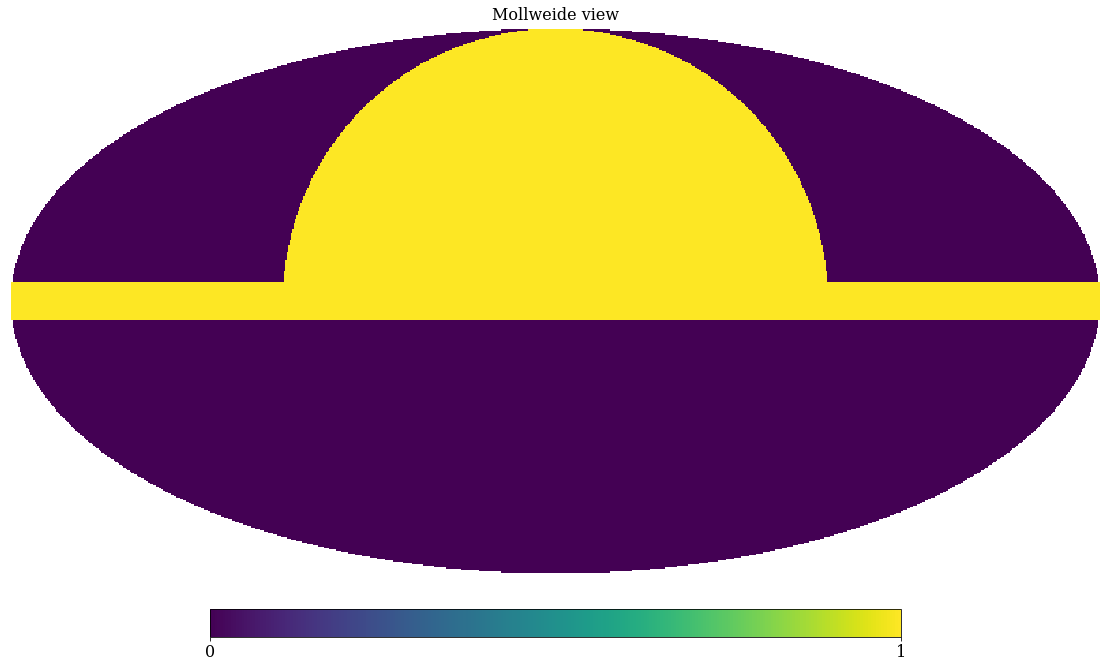

In [16]:
mask = np.zeros(hp.nside2npix(Nside), dtype=np.float32)

# Galactic survey mask
gal_cut = np.radians(5.0)
wgal = hp.query_strip(Nside, np.pi/2-gal_cut, np.pi/2+gal_cut)


# Extragalactic survey mask
ipix = np.linspace(0, hp.nside2npix(Nside), hp.nside2npix(Nside), dtype=int)
angle = hp.pix2ang(Nside, ipix, lonlat=True)
maplon = angle[0]
maplat = angle[1]
maplon[maplon>180] = (maplon[maplon>180]-360)
weg = (maplon >= -90) * (maplon <= +90) * (maplat >= 5)

mask[weg] = 1
mask[wgal] = 1

fig = plt.figure(0, figsize=(20,10))
hp.mollview(mask, fig=0)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_over(newcm(1.0))
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_under(bgcolor)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colo

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_over(newcm(1.0))
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_under(bgcolor)
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colo

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


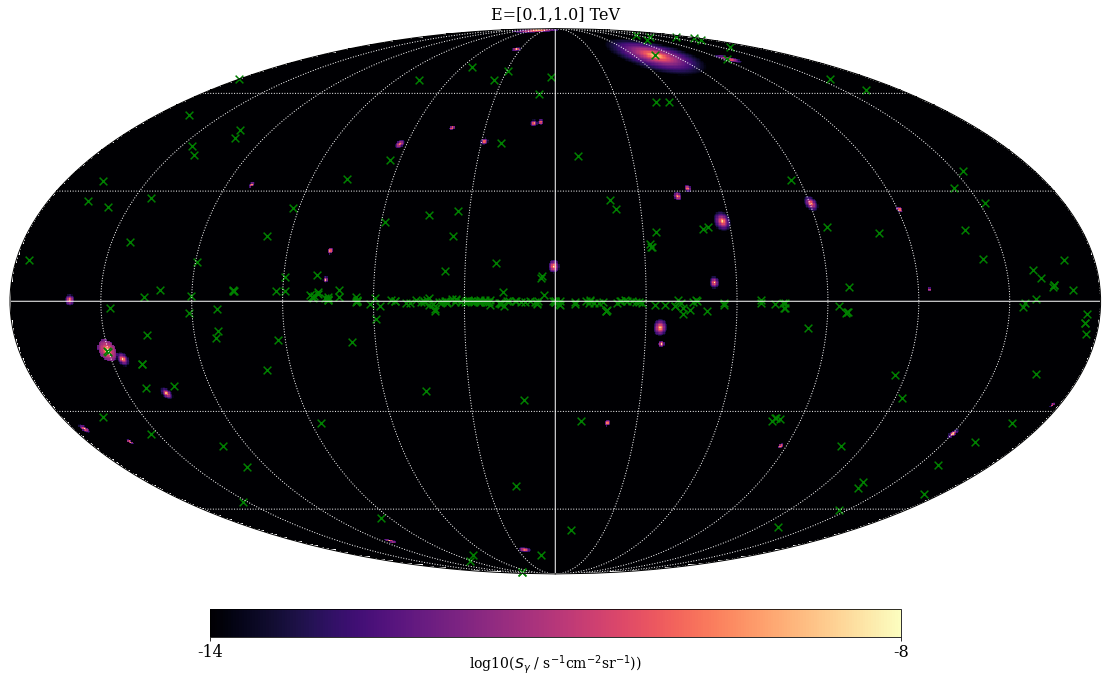

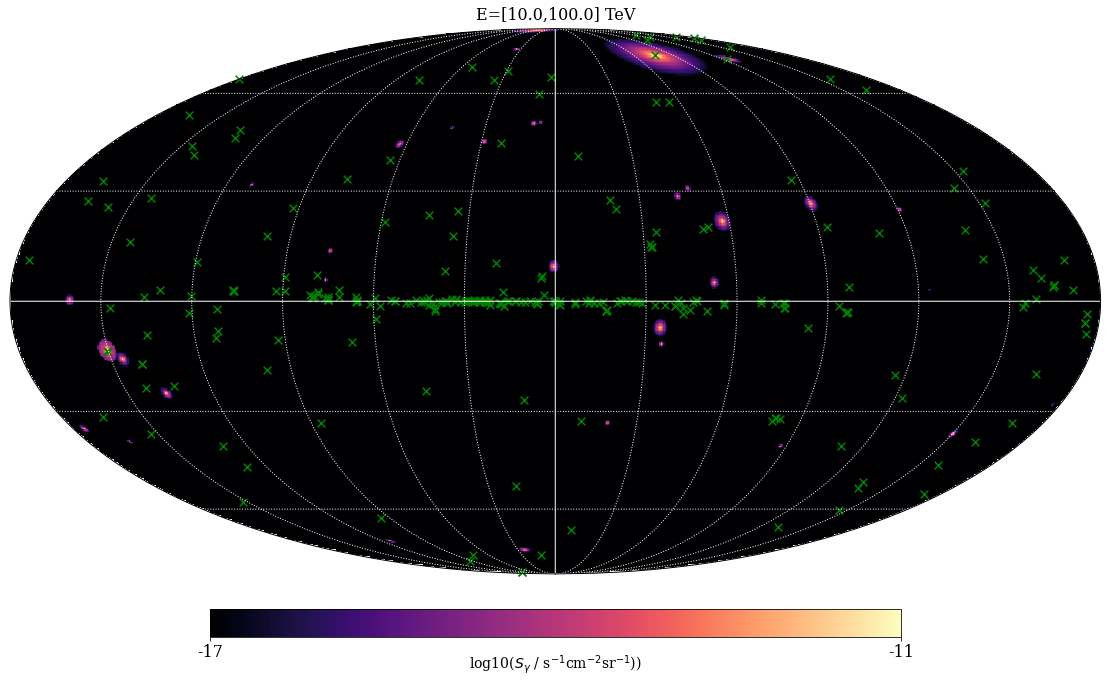

In [38]:
#---------- Show the first and last energy bins
skymap_show = skymap[0,:]
skymap_show[skymap_show<=1e-16] = 1e-16
skymap_show = np.log10(skymap_show)
fig = plt.figure(0, figsize=(20,10))
hp.mollview(skymap_show, 
            min=-14, max=-8, 
            cmap='magma', fig=0,
            unit="log10($S_{\gamma}$ / s$^{-1}$cm$^{-2}$sr$^{-1}$))",
            title='E=['+str(Ebin_pot[0].to_value('TeV'))+','+str(Ebin_pot[0+1].to_value('TeV'))+'] TeV')
hp.visufunc.projscatter(tevcat_coord.galactic.l.to_value('deg'), tevcat_coord.galactic.b.to_value('deg'), 
                        lonlat=True, s=60, marker='x', color='green', edgecolors='white')
hp.graticule(color='white')
fig.savefig(workdir+'skymap_FirstEbin_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

skymap_show = skymap[Ebin_nbin-1,:]
skymap_show[skymap_show<=1e-20] = 1e-20
skymap_show = np.log10(skymap_show)
fig = plt.figure(1, figsize=(20,10))
hp.mollview(skymap_show, 
            min=-17, max=-11,
            cmap='magma', fig=1, 
            unit="log10($S_{\gamma}$ / s$^{-1}$cm$^{-2}$sr$^{-1}$))",
            title='E=['+str(Ebin_pot[Ebin_nbin-1].to_value('TeV'))+','+str(Ebin_pot[Ebin_nbin].to_value('TeV'))+'] TeV',)
hp.visufunc.projscatter(tevcat_coord.galactic.l.to_value('deg'), tevcat_coord.galactic.b.to_value('deg'), 
                        lonlat=True, s=60, marker='x', color='green', edgecolors='white')
hp.graticule(color='white', label=True)
fig.savefig(workdir+'skymap_LastEbin_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

In [29]:
workdir+'skymap_FirstEbin_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf'

'/Users/adam/Project/CTA/Phys/Outputs/CTADC2022/skymap_FirstEbin_V2_PSZmassFalse.pdf'

In [18]:
#---------- Save the maps as fits files
filename = workdir+'cluster_sky_map_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.fits'

column_names = []
for ieb in range(Ebin_nbin):
    column_names.append('Gamma-ray in E=['+str(Ebin_pot[ieb].to_value('GeV'))+','+str(Ebin_pot[ieb+1].to_value('GeV'))+'] GeV')

hp.write_map(filename, skymap, overwrite=True, fits_IDL=False,
             column_names=column_names,
             column_units='s-1 sr-1 cm-2')

Ebin_hdr = fits.Header()
Ebin_hdr.add_comment('Energy bin edges (GeV)')
fits.append(filename, Ebin_pot.to_value('GeV'), Ebin_hdr)

# Validation with Perseus

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
85.76508819532087 94.23491180467911 -4.234911804679125 4.234911804679125
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


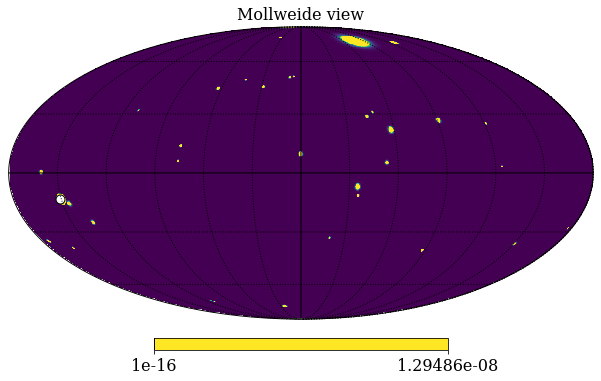

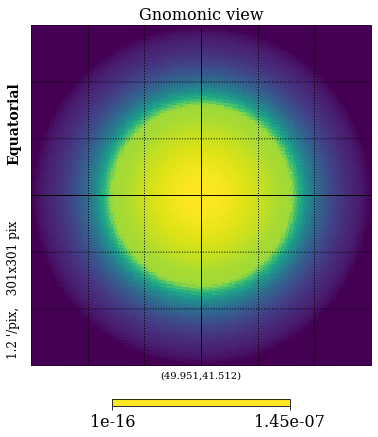

In [19]:
#---------- Get the Perseus definition
perseus = perseus_model_library.default_model()
perseus.output_dir = workdir
perseus.cosmo = cosmo
perseus.Npt_per_decade_integ = Npt_per_decade
perseus.R_truncation = 5*perseus.R500
perseus.map_reso = 0.02*u.deg
perseus.map_fov  = 6*u.deg

#---------- Extract Perseus (first energy bin) from the healpix map
gmap_hp, gheader = minot.ClusterTools.map_tools.roi_extract_healpix(filename, perseus.coord.ra.value, perseus.coord.dec.value, 
                                                 perseus.map_reso.to_value('deg'), 
                                                 [perseus.map_fov[0].to_value('deg'), perseus.map_fov[1].to_value('deg')],
                                                 visu=True)
#---------- Set match the headers
perseus.map_header = gheader

In [20]:
#---------- Compute
sigma_smooth = 2
perseus_map = perseus.get_gamma_map(Emin=Ebin_pot[0], Emax=Ebin_pot[0+1],
                                    Rmin_los=1*u.kpc, NR500_los=3.0, Rmin=1*u.kpc, Rmax=3*perseus.R500, 
                                    Energy_density=False, Cframe=False, model='Kafexhiu2014')
gmap_hp_filt     = gfilter(gmap_hp, sigma=sigma_smooth)
perseus_map_filt = gfilter(perseus_map.to_value('s-1 sr-1 cm-2'), sigma=sigma_smooth)

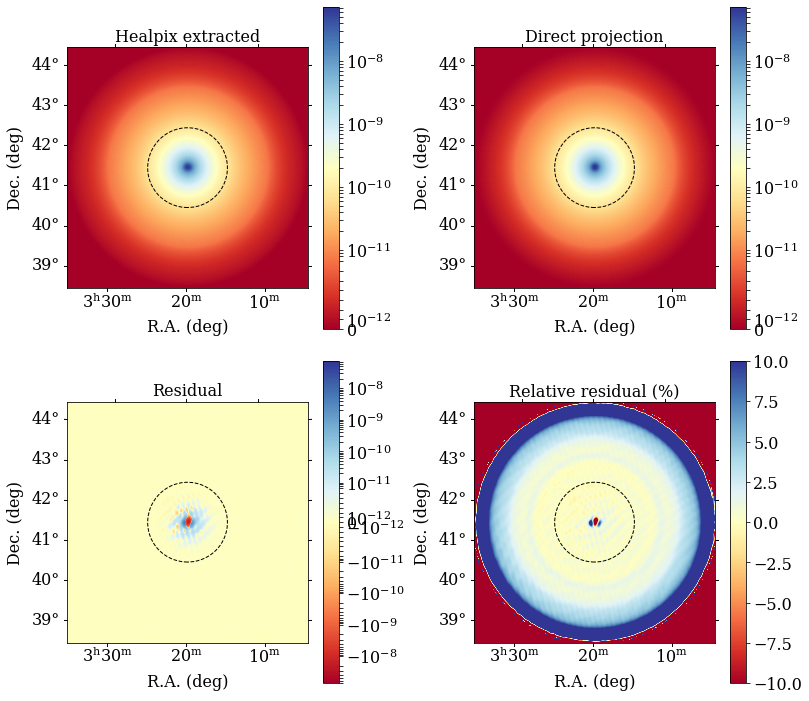

In [21]:
#---------- Show the maps and difference
rad = perseus.theta500.to_value('deg')

fig = plt.figure(0, figsize=(12, 10))
ax = plt.subplot(221, projection=WCS(gheader))
plt.imshow(gmap_hp_filt, 
           norm=SymLogNorm(np.amax(gmap_hp_filt)/1e4, vmin=0, vmax=np.amax(gmap_hp_filt), base=10), 
           origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Healpix extracted')

ax = plt.subplot(222, projection=WCS(gheader))
plt.imshow(perseus_map_filt, 
           norm=SymLogNorm(np.amax(gmap_hp_filt)/1e4, vmin=0, vmax=np.amax(gmap_hp_filt), base=10), 
           origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Direct projection')

ax = plt.subplot(223, projection=WCS(gheader))
plt.imshow(gmap_hp_filt - perseus_map_filt, 
           norm=SymLogNorm(np.amax(gmap_hp_filt)/1e4, vmin=-np.amax(gmap_hp_filt), vmax=np.amax(gmap_hp_filt), base=10), 
           origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Residual')

ax = plt.subplot(224, projection=WCS(gheader))
plt.imshow((gmap_hp_filt - perseus_map_filt)/perseus_map_filt*100, vmin=-10, vmax=10, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((perseus.coord.ra.value, perseus.coord.dec.value),2*rad/np.cos(perseus.coord.dec.value*np.pi/180), 2*rad,linewidth=1, fill=False, zorder=2,edgecolor='black', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
plt.colorbar()
plt.title('Relative residual (%)')

plt.subplots_adjust(left=None, bottom=0.05, right=None, top=0.99, wspace=0.35, hspace=0.10)
plt.savefig(workdir+'Validation_Projection_Perseus.pdf')

# Scaling relation and model

In [22]:
# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


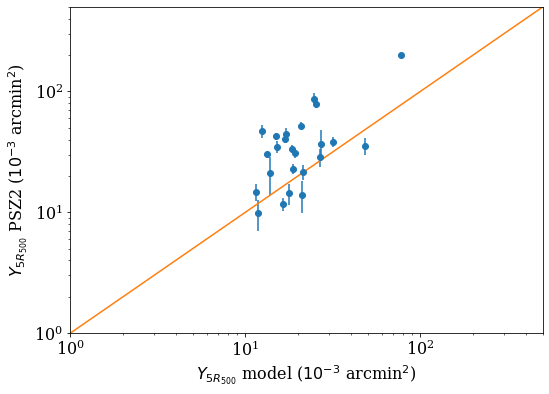

In [23]:
if do_validation:
    plt.errorbar(cat_y_mod, cat_y_psz2, yerr=cat_yerr_psz2, marker='o', ls='')
    plt.errorbar(cat_y_mod[cat_name == 'A0426'], cat_y_psz2[cat_name == 'A0426'], yerr=cat_yerr_psz2[cat_name == 'A0426'], color='red', marker='s', ls='', label='Perseus')
    plt.plot(np.linspace(0.1,1000),np.linspace(0.1,1000))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,500)
    plt.ylim(1,500)
    plt.xlabel('$Y_{5 R_{500}}$ model ($10^{-3}$ arcmin$^2$)')
    plt.ylabel('$Y_{5 R_{500}}$ PSZ2 ($10^{-3}$ arcmin$^2$)')
    plt.savefig(workdir+'Validation_Y5R500_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

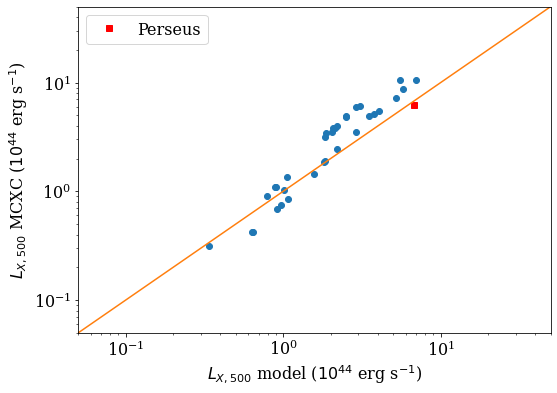

In [24]:
if do_validation:
    plt.plot(cat_Lx_mod, cat_Lx_mcxc, marker='o', ls='')
    plt.plot(cat_Lx_mod[cat_name == 'A0426'], cat_Lx_mcxc[cat_name == 'A0426'], color='red', marker='s', ls='', label='Perseus')
    plt.plot(np.linspace(0.01,50),np.linspace(0.01,50))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.05,50)
    plt.ylim(0.05,50)
    plt.xlabel('$L_{X,500}$ model ($10^{44}$ erg s$^{-1}$)')
    plt.ylabel('$L_{X,500}$ MCXC ($10^{44}$ erg s$^{-1}$)')
    plt.legend()
    plt.savefig(workdir+'Validation_Lx500_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')

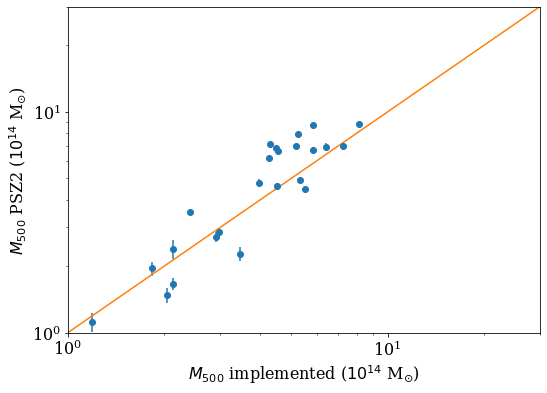

In [25]:
if do_validation:
    plt.errorbar(cat_mass, cat_m_psz2, yerr=cat_merr_psz2, marker='o', ls='')
    plt.plot(np.linspace(1,50),np.linspace(1,50))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,30)
    plt.ylim(1,30)
    plt.xlabel('$M_{500}$ implemented ($10^{14}$ M$_{\odot}$)')
    plt.ylabel('$M_{500}$ PSZ2 ($10^{14}$ M$_{\odot}$)')
    plt.savefig(workdir+'Validation_M500_PSZ2_MCXC_V'+str(version)+'_PSZmass'+str(use_psz_mass)+'.pdf')